### Optical pulse broadening in optical filter

In [39]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
from scipy.fft import fft, fftshift, fftfreq
from scipy.constants import c

from prbs_def import prbs_1, prbs_2

In [40]:
def propagate(phase1, phase2, Ein=np.array([[1],[0]])):

    propagatematrix1 = np.array([[np.exp(1j*phase1),0],[0,np.exp(1j*phase2)]]);

    Eout = np.dot(propagatematrix1,Ein)
    
    return Eout


def beamsplitter(PT,Ein):

   # See Wikipedia for details. https://en.wikipedia.org/wiki/Beam_splitter       

   # Dielectric type Beam Splitter
     #phiT = 0
     #phiR = 0
     #phiO = 0

   # Symmetric type Beam Splitter
     phiT = 0
     phiR = -0.5 * np.pi    
     phiO = 0.5 * np.pi
     
     T = np.sqrt(PT) # Transmission defined as Electric field

     PR = 1-PT 

     R = np.sqrt(PR) # Reflection defined as Electric field

     Theta1 = np.arctan(R/T) # Split Raio in Radian   
         
     BSmatrix1 = np.dot(np.exp(1J*phiO),np.array([[np.sin(Theta1)*np.exp(1J*phiR),np.cos(Theta1)*np.exp(-1J*phiT)],[np.cos(Theta1)*np.exp(1j*phiT),-1*np.sin(Theta1)*np.exp(-1J*phiR)]]))
     
     Eout = np.dot(BSmatrix1, Ein)

     return Eout

In [41]:

def generate_pulse_train(duty_ratio, frequency, duration, sampling_rate=1000):
    # Calculate the period of the pulse train
    period = 1.0 / frequency
    
    # Calculate the number of samples for high and low parts of the signal
    high_samples = int(duty_ratio * period * sampling_rate)
    low_samples = int((1 - duty_ratio) * period * sampling_rate)
    
    # Create one period of the pulse train
    pulse_one_period = np.concatenate([np.ones(high_samples), np.zeros(low_samples)])
    
    # Calculate the total number of samples
    total_samples = int(duration * sampling_rate)
    
    # Repeat the pulse train to cover the entire duration
    pulse_train = np.tile(pulse_one_period, int(np.ceil(total_samples / len(pulse_one_period))))[:total_samples]
    
    return pulse_train




t_step: 2e-16
Light Frequency1: lightfreq1 [Hz]
1.93414E+14

Light Frequency2: lightfreq2 [Hz]
1.93414E+14

Difference Frequency: freq_diff [Hz]
0.00000E+00



ValueError: x and y must have same first dimension, but have shapes (262144,) and (524288,)

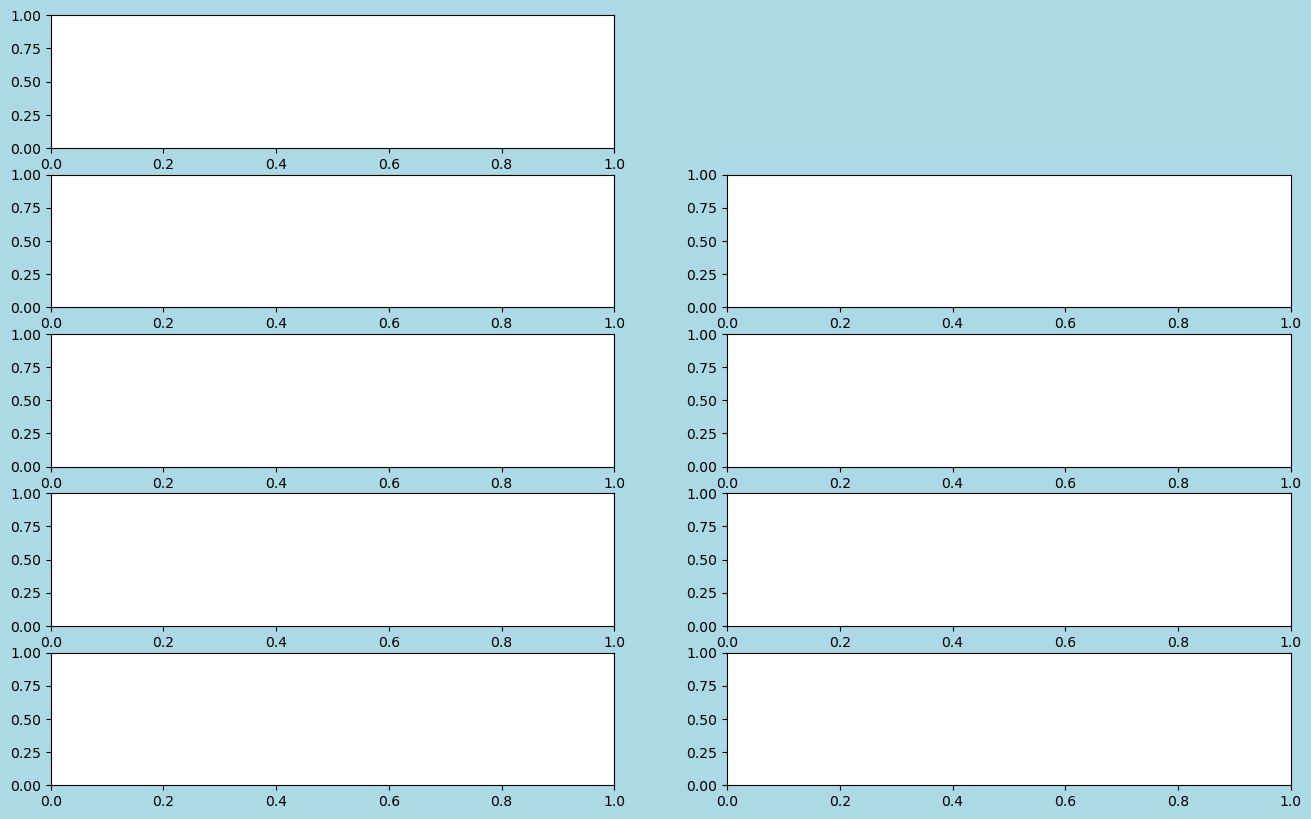

In [42]:
samplerate = 2**18 # Number of Points
t_step = 2e-16 #[s]
print('t_step:', t_step)
tcol = np.linspace(0.0, t_step * samplerate, samplerate, endpoint=False)

amp_c = 0.5 * np.pi
freq_rf = 400e9 # [Hz]

md = 1 # modulation depth. 1 = 100 %
dc_offset = 0 # DC offset

#Sine
#rfsignalcol = amp_c * np.sin(2 * np.pi * freq_rf * tcol) + dc_offset #[rad]

#Rectangular
#rfsignalcol = amp_c *signal.square(2 * np.pi * freq_rf * tcol) +dc_offset #[rad] 

#prbs
#rfsignalcol = prbs_1(samplerate, a1_range = [0,1], b1_range = [10, 50])
#rfsignalcol = prbs_2(samplerate, numberofpointspersymbol = 2 ** 6)

#----
# Parameters
duty_ratio = 0.3  # Duty ratio (e.g., 30% high, 70% low)
frequency = 5.0   # Frequency of the pulse train in Hz
duration = 2.0    # Duration of the pulse train in seconds
#sampling_rate = 1000  # Sampling rate in samples per second

# Generate the pulse train
rfsignalcol = generate_pulse_train(duty_ratio, frequency, duration, samplerate)
#----

# Plot the pulse train
#plt.figure(figsize=(10, 4))
#plt.plot(np.arange(len(pulse_train)) / sampling_rate, pulse_train, label=f'Duty Ratio: {duty_ratio * 100}%')
#plt.xlabel('Time (s)')
#plt.ylabel('Amplitude')
#plt.title('Pulse Train with Variable Duty Ratio')
#plt.legend()
#plt.grid(True)
#plt.show()

no = 1 # Refractive Index of medium

wl1 = 1550e-9 
wl2 = 1550e-9

oplcommon1=100 #Common Path Length 1
oplcommon2=100 #Common Path Length 2

opl1 =100 
opl2= 100


# If wl1 and wl2 are equal, homodyne. If not, heterodyne.

lightfreq1 = c / wl1
print("Light Frequency1: lightfreq1 [Hz]")
print(f'{lightfreq1:.5E}')
print("")

lightfreq2 = c / wl2
print("Light Frequency2: lightfreq2 [Hz]")
print(f'{lightfreq2:.5E}')
print("")

freq_diff = lightfreq1-lightfreq2

print("Difference Frequency: freq_diff [Hz]")
print(f'{freq_diff:.5E}')
print("")

PT1 = 0.5 # PT: Power Transmission of Beam splitter

# Define Input Electric Field: Both 1 and 2 port

#Ein1 = np.array([[1+0j],[1-0j]]) 
Ein1 = np.array([[0.707+0.707j],[-0.707-0.707j]])
#Ein1 = np.array([[1 + 0j],[-1 - 0j]])

Port1_1_EFcol = np.zeros(samplerate, dtype=complex)
Port1_2_EFcol = np.zeros(samplerate, dtype=complex)
Port3_1_EFcol = np.zeros(samplerate,dtype=complex)
Port3_2_EFcol = np.zeros(samplerate, dtype=complex)
Port3_1_powercol = np.zeros(samplerate)
Port3_2_powercol = np.zeros(samplerate)
Power_diffcol = np.zeros(samplerate)



for ii in range(samplerate):
    
    t = tcol[ii]
    rf_signal = rfsignalcol[ii]
    
    #amp_c * np.sin(2 * np.pi * freq_rf * t) + dc_offset #[rad]
    #rfsignalcol[ii] = rf_signal  
    
    # Path Length modulated

    phase1 = 2*np.pi * lightfreq1 * t # phase of local oscillator [rad]
    
    #phase2 = 2*np.pi * lightfreq2 * t # Phase of Continious Wave [rad]
    phase2 = 2*np.pi * lightfreq2 * t + rf_signal # Phase of Modulated Light [rad]

    Eout1 = propagate(phase1, phase2, Ein1)
    
    Port1_1_Eout = Eout1[0,0] # Modulated Light signal
    Port1_1_EFcol[ii] = Port1_1_Eout
    
    Port1_2_Eout = Eout1[1,0] # Local Oscillator
    Port1_2_EFcol[ii] = Port1_2_Eout

    Ein2 = Eout1

    Eout2 = beamsplitter(PT1, Ein2)
    Ein3 = Eout2    
   
    Eout3 = propagate(1, 1, Ein3)
    
    #Trans
    Port3_1_Eout = Eout3[0,0]
    Port3_1_EFcol[ii] = Port3_1_Eout

    power3_1 = (np.abs(Port3_1_Eout))**2 # Optical power is calculated as squared of absolute electric field strength
    Port3_1_powercol[ii] = power3_1

    #Reflect
    Port3_2_Eout = Eout3[1,0] 
    Port3_2_EFcol[ii] = Port3_2_Eout

    power3_2 = (np.abs(Port3_2_Eout))**2
    Port3_2_powercol[ii] = power3_2
    
    # Power Difference
    Power_diff = power3_1 - power3_2
    Power_diffcol[ii] = Power_diff
 
fig1 = plt.figure(figsize = (16,10), facecolor='lightblue')
ax1_1 = fig1.add_subplot(5, 2, 1)
ax1_3 = fig1.add_subplot(5, 2, 3)
ax1_4 = fig1.add_subplot(5, 2, 4)
ax1_5 = fig1.add_subplot(5, 2, 5)
ax1_6 = fig1.add_subplot(5, 2, 6)
ax1_7 = fig1.add_subplot(5, 2, 7)
ax1_8 = fig1.add_subplot(5, 2, 8)
ax1_9 = fig1.add_subplot(5, 2, 9)
ax1_10 = fig1.add_subplot(5, 2, 10)


ax1_1.plot(tcol,rfsignalcol)
ax1_1.set_ylabel("RF signal [rad]")

ax1_3.plot(tcol,np.real(Port1_1_EFcol))
ax1_3.set_ylabel("Real Part of EF")

ax1_5.plot(tcol,np.real(Port1_2_EFcol))
ax1_5.set_ylabel("Real Part of EF")

ax1_7.plot(tcol,Port3_1_powercol,tcol,Port3_2_powercol)
ax1_7.set_ylabel("Optical Power [W]")
ax1_7.set_ylim(-0.2,2.2)

ax1_9.plot(tcol,Power_diffcol)
ax1_9.set_xlabel("time [s]")
ax1_9.set_ylabel("Difference between two PD signals [W]")


xf = fftfreq(samplerate, t_step)[:samplerate//2]

Port1_1_EFcol_f = fft(Port1_1_EFcol)
Port1_2_EFcol_f = fft(Port1_2_EFcol)

ax1_4.plot(xf, 2.0/samplerate * np.abs(Port1_1_EFcol_f[0:samplerate//2]),label="Port1_1")
ax1_4.set_xlim(190e12,200e12)
ax1_4.legend()
ax1_4.grid(True)

ax1_6.plot(xf, 2.0/samplerate * np.abs(Port1_2_EFcol_f[0:samplerate//2]),label="Port1_2")
ax1_6.set_xlim(190e12,200e12)
ax1_6.legend()
ax1_6.grid(True)

Port1_powercol_f = fft(Port3_1_powercol)
Port2_powercol_f = fft(Port3_2_powercol)

ax1_8.plot(xf, 2.0/samplerate * np.abs(Port1_powercol_f[0:samplerate//2]),label="Port1 Power")
ax1_8.set_ylabel("Power Spectrum")
ax1_8.set_xlim(-1e12,6e12)
ax1_8.legend()


ax1_8.plot(xf, 2.0/samplerate * np.abs(Port2_powercol_f[0:samplerate//2]), label="Port2 Power")
ax1_8.set_ylabel("Power Spectrum")
ax1_8.set_xlim(-1e12,6e12)
ax1_8.legend()


Power_diffcol_f = fft(Power_diffcol)
ax1_10.plot(xf, 2.0/samplerate * np.abs(Power_diffcol_f[0:samplerate//2]), label="Power Difference")
ax1_10.set_xlabel("Frequency [Hz]")
ax1_10.set_ylabel("Power Difference Spectrum")
ax1_10.set_xlim(-1e12,6e12)
ax1_10.legend()

fig2 = plt.figure(figsize = (16,10), facecolor='lightblue')
ax2_3 = fig2.add_subplot(5, 2, 3)
ax2_4 = fig2.add_subplot(5, 2, 4)
ax2_5 = fig2.add_subplot(5, 2, 5)
ax2_6 = fig2.add_subplot(5, 2, 6)
ax2_7 = fig2.add_subplot(5, 2, 7)
ax2_8 = fig2.add_subplot(5, 2, 8)
ax2_9 = fig2.add_subplot(5, 2, 9)
ax2_10 = fig2.add_subplot(5, 2, 10)

#nn = 2 ** 14 # number of 
nn = samplerate # number of 

ax2_3.plot(tcol[0:nn],np.real(Port3_1_EFcol[0:nn]))
ax2_3.set_ylabel("Real Part of EF")
ax2_3.set_ylim(-2,2)

ax2_5.plot(tcol[0:nn],np.real(Port3_2_EFcol[0:nn]))
ax2_5.set_ylabel("Real Part of EF")
ax2_5.set_ylim(-2,2)

#plt.savefig(f"{wl2}_{freq_rf}.png", dpi=300)

plt.show()

In [ ]:

N = 2* samplerate

frequencystep = (1/t_step) * (1/N)
print("frequencystep: ", frequencystep)

Shifted_sampleIndex = np.arange(-N//2, N//2)
Shifted_f = Shifted_sampleIndex*frequencystep

fft_random_analog_signal = fft(Port3_1_EFcol,N)
Shifted_fft_random_analog_signal = fftshift(fft_random_analog_signal)

print('Shape of Shifted_fft_random_analog_signal (Frequency Domain)')
print(Shifted_fft_random_analog_signal.shape)
print('')

print('Shape of Shifted_f (Frequency Domain)')
print(Shifted_f.shape)
print('')

fig1 = plt.figure(figsize = (10,6), facecolor='lightblue')

ax1_1 = fig1.add_subplot(2, 1, 1)
ax1_1.set_title("Optical spectrum")
ax1_1.stem(Shifted_f, np.abs(Shifted_fft_random_analog_signal),"k",label='Intensity moduated light signal')
ax1_1.set_xlabel("Optical Frequency [Hz]")
#ax1_1.set_xlim(190e12,200e12)
#ax1_1.set_xlim(0, frequencystep * samplerate * 1.1/1)
ax1_1.legend()
ax1_1.grid()


norm_freqcol = np.linspace(-1*np.pi, 1*np.pi, N, endpoint=False)

fig2 = plt.figure(figsize = (10,6), facecolor='lightblue')
ax2_1 = fig2.add_subplot(2, 1, 1)
ax2_1.stem(norm_freqcol, np.abs(Shifted_fft_random_analog_signal),"k",label='Intensity moduated light signal')
ax2_1.set_title("Normalized Optical spectrum")
ax2_1.set_xlabel("Normalized Frequency [rad]")
ax2_1.legend()
ax2_1.set_xlim(0, 1.05*np.pi)
ax2_1.grid()



### Filter Design

In [ ]:
norm_freqcol = np.linspace(-1*np.pi, 1*np.pi, 2*samplerate, endpoint=False)

# Setting standard filter requirements.
order = 8
lowcut = 0.05 # / np.pi # [Normalized Frequency. 0 to 1]
highcut = 0.4 # / np.pi

b, a = signal.butter(order, [lowcut, highcut], btype='bandpass')

#print('b = ', b)
#print('a = ', a)

# Plotting the frequency response.
w, h = signal.freqz(b, a) # scipy.signal.freqz: Digital Filter

fig1 = plt.figure(figsize = (12,6), facecolor='white')
ax1_1 = fig1.add_subplot(2, 1, 1)
ax1_1.plot(w, np.abs(h), 'b')

#ax1_1.plot(lowcut, 0.5*np.sqrt(2), 'ko')
#ax1_1.axvline(highcut * np.pi, color='g')
ax1_1.set_title("Bandpass Filter Frequency Response")
#ax1_1.set_xlim(0.0*np.pi , 1.1*np.pi)

ax1_1.set_xlabel('Normalized Frequency')
ax1_1.grid()

ax1_1.stem(norm_freqcol, np.abs(Shifted_fft_random_analog_signal)/np.max(np.abs(Shifted_fft_random_analog_signal)),"k.",label='Shifted_fft_SelfMixed_carrier_wavecol')

ax1_2 = fig1.add_subplot(2, 1, 2)
ax1_2.plot(w, np.angle(h), 'g')
#ax1_2.set_xlim(0.0*np.pi , 1.1*np.pi)

filtered_data1 = signal.lfilter(b, a, Port3_1_EFcol) # scipy.signal.lfilter

fig3 = plt.figure(figsize = (12,8), facecolor='white')
ax3_1 = fig3.add_subplot(3, 1, 1)
ax3_1.plot(tcol,np.real(Port3_1_EFcol),'-', color="r",label='original data' )
ax3_1.set_ylabel("Electric Field")
ax3_1.grid()
ax3_1.legend()
ax3_1.set_title("Time domain")

ax3_2 = fig3.add_subplot(3, 1, 2)
ax3_2.plot(tcol, np.real(filtered_data1), 'g.-', linewidth=1, label='Filtered data')
ax3_2.set_ylabel("Electric Field")
ax3_2.grid()
ax3_2.legend()

ax3_3 = fig3.add_subplot(3, 1, 3)
ax3_3.plot(tcol, (np.abs(filtered_data1))**2, 'g-', linewidth=2, label='Filtered data')


ax3_3.set_xlabel('Time [sec]')
ax3_3.set_ylabel("Optical Power")
ax3_3.grid()
ax3_3.legend()
